## Imports

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [6]:
import pandas as pd

# Setting seed & importing data

In [7]:
tf.random.set_seed(8)

df = pd.read_csv('data/original_data.csv')
df.head()

,headline,label
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
df.isna().sum()

headline    0
label       0
dtype: int64

In [9]:
df.shape

(26709, 2)

## Splitting data

In [10]:
X = df["headline"]
y = df["label"]

splitting data 70\% train, 10\% validation, 20\% test

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=8)

In [12]:
X_train.sample(4)

25050               ad campaign for new $20 bill a success
5425     silvio berlusconi transferred to steamy all-fe...
17105               the sound of president trump's silence
12848     6,000-year-old culture now a 'developing nation'
Name: headline, dtype: object

## Tokenization and padding

In [13]:
# tokenizing:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# padding:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

max_length = max(len(sequence) for sequence in sequences_train)

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')


print(padded_train[0:3])
print(max_length)

[[ 6553  1214  1060  6554  8497  6555     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [   36  1015    27  8498  1215   524 12215   112    51    13    89  1984
    118   293     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 1739    13    38     4    86    83    56    15    36    39   711    14
   8499  4017   605    91   174     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
40


## Embedding

In [25]:
vocab_size = len(word_index) + 1
embed_dim = 100

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=max_length),
    # tf.keras.layers.GlobalAveragePooling1D(),
    #LSTM Layer
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),  # Dropout layer added
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 100)           2476300   
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2493357 (9.51 MB)
Trainable params: 2493357 (9.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [26]:
num_epochs = 6

history_lstm = model_lstm.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_val, y_val), verbose=2, callbacks=early_stopping)

Epoch 1/6
585/585 - 29s - loss: 0.6582 - accuracy: 0.5972 - val_loss: 0.5292 - val_accuracy: 0.7436 - 29s/epoch - 50ms/step
Epoch 2/6
585/585 - 26s - loss: 0.4941 - accuracy: 0.8042 - val_loss: 0.5113 - val_accuracy: 0.7935 - 26s/epoch - 45ms/step
Epoch 3/6
585/585 - 26s - loss: 0.4466 - accuracy: 0.8388 - val_loss: 0.5205 - val_accuracy: 0.7844 - 26s/epoch - 44ms/step
Epoch 4/6
Restoring model weights from the end of the best epoch: 2.
585/585 - 27s - loss: 0.4075 - accuracy: 0.8533 - val_loss: 0.5309 - val_accuracy: 0.7833 - 27s/epoch - 46ms/step
Epoch 4: early stopping


## Plotting curves

In [17]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

C:/Users/olivi/AppData/Local/Temp/xpython_27260/2336864335.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


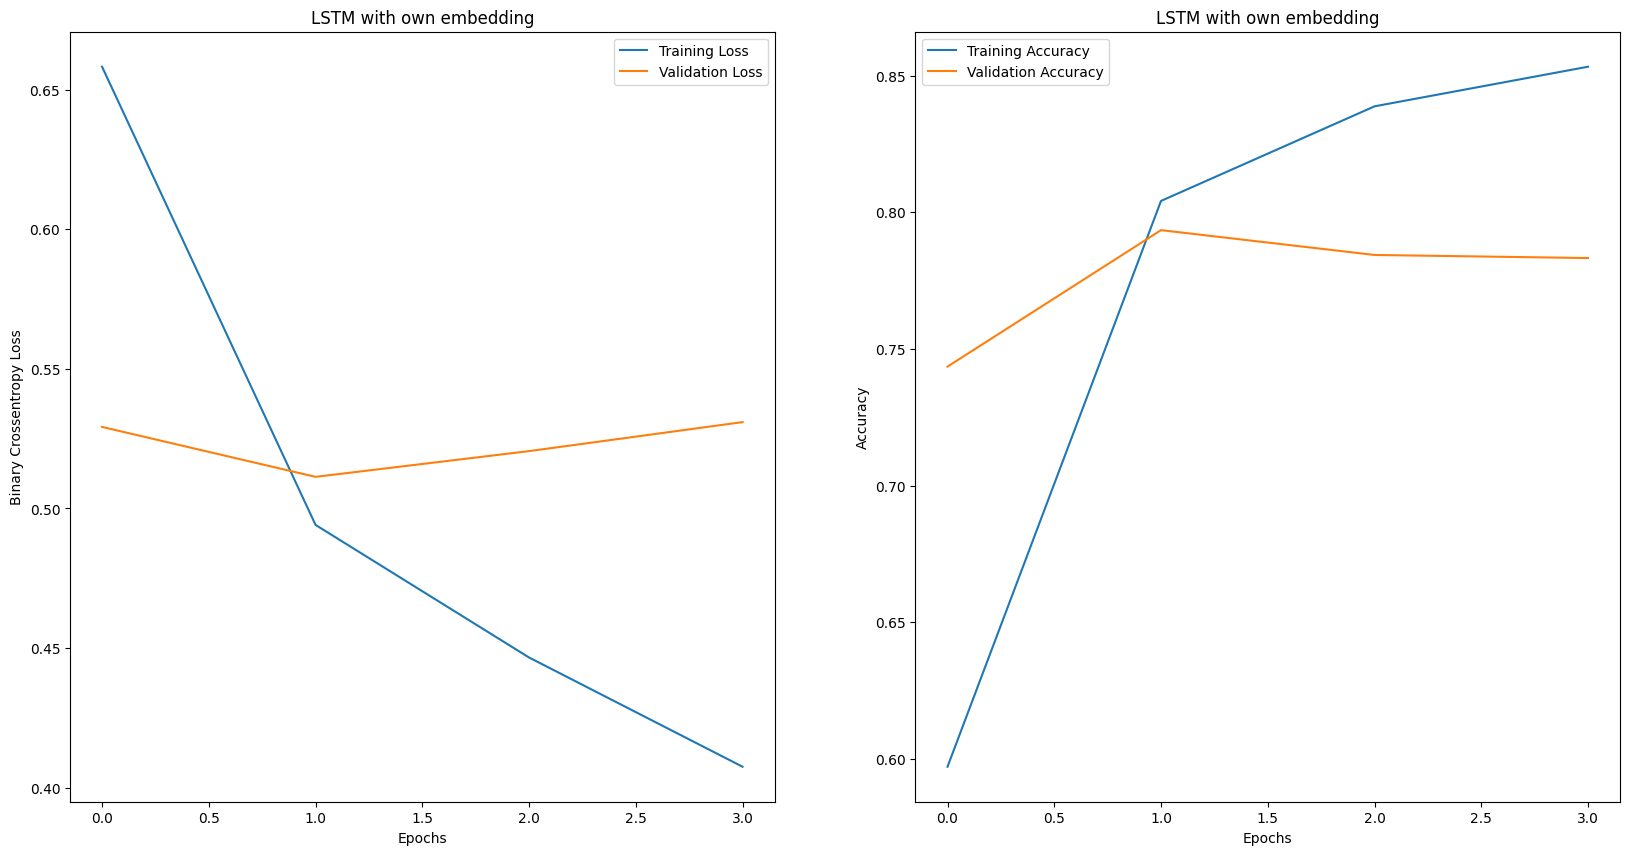

In [27]:
## LSTM with own embedding
plotCurves(history_lstm, "LSTM with own embedding")